<a href="https://colab.research.google.com/github/ucheokechukwu/ml_tensorflow_deeplearning/blob/main/07_milestone_project_1_food_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Check GPU

Mixed precision training - uses both 16 and 32 bit types which makes it run faster during training.
Special hardware units called tensor cores.
Google colab offers:
K80 (not compatible)
P100 (not compatible)
Tesla T4 compatible


## Getting the helper functions
In past modules, we have helper functions that we import instead of re-writing the script.

In [2]:
# download helper function script

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-03-05 13:37:45--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-05 13:37:45 (86.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# import series of helper functions for the notebook 
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use Tensorflow Datasets to download data
Tensorflow Datasets is a collection of ready-to-use datasets (already in Tensorflow format) with Tensorflow  or other Python ML frameworks. All datasets are exposed as `tf.data.Datasets`, enabling easy to use and high-performanc input pipelines.

https://www.tensorflow.org/datasets

Why use this?
- load data already in tensor format
- practice in well established datasets
- experiment with different modelling techniques on a consistent dataset

why not use this?
- datasets are static and do not change like real-world datasets

In [4]:
# Get tensorflow dataset
import tensorflow_datasets as tfds

In [5]:
# list all available datasets
datasets_list = tfds.list_builders() # get all available datasets in tfds
print("food101" in datasets_list) # is our target in the list of tfds

True


In [6]:
!nvidia-msi

/bin/bash: nvidia-msi: command not found


* note that this is a lot and takes a long time

In [7]:
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train","validation"],
                                             shuffle_files=True,
                                             as_supervised=True, #data gets returned in tuple format (data,label)
                                             with_info=True) #metadata is downloaded as well and saved into ds_info

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteHJM5BA/food101-train.tfrecord*...:   0%|          …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteHJM5BA/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the Food1010 data from Tensorflow datasets

To become one with our data, we need to find:
* Class names
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels looks like (e.g. are they one-hot encoded or are they label encoded?)
* Do the labels match up with the class names?


In [8]:
# features of food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [9]:
# get the class names (we have to dig into the metadata ds_info)
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [10]:
# get one sample of our training data (remember: start small and increase complexity)
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [25]:
train_one_sample = train_data.take(10)
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [26]:
# output info about our training sample
for image, label in train_one_sample:
  print(f"""
  image_shape: {image.shape}
  image_datatype: {image.dtype}
  target class from food101 (tensor form): {label}
  class name (str form): {class_names[label.numpy()]}
  """)


  image_shape: (512, 512, 3)
  image_datatype: <dtype: 'uint8'>
  target class from food101 (tensor form): 30
  class name (str form): deviled_eggs
  

  image_shape: (512, 382, 3)
  image_datatype: <dtype: 'uint8'>
  target class from food101 (tensor form): 73
  class name (str form): panna_cotta
  

  image_shape: (489, 512, 3)
  image_datatype: <dtype: 'uint8'>
  target class from food101 (tensor form): 90
  class name (str form): spaghetti_bolognese
  

  image_shape: (512, 512, 3)
  image_datatype: <dtype: 'uint8'>
  target class from food101 (tensor form): 93
  class name (str form): steak
  

  image_shape: (512, 512, 3)
  image_datatype: <dtype: 'uint8'>
  target class from food101 (tensor form): 37
  class name (str form): filet_mignon
  

  image_shape: (512, 512, 3)
  image_datatype: <dtype: 'uint8'>
  target class from food101 (tensor form): 66
  class name (str form): nachos
  

  image_shape: (512, 512, 3)
  image_datatype: <dtype: 'uint8'>
  target class from food101 (t

In [14]:
import tensorflow as tf

In [15]:
# what does our image tensor look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 19,   6,   0],
        [ 29,  16,   8],
        [ 34,  21,  13],
        ...,
        [ 36,  19,   3],
        [ 35,  19,   3],
        [ 36,  20,   4]],

       [[ 20,   7,   0],
        [ 28,  15,   7],
        [ 34,  21,  13],
        ...,
        [ 37,  20,   4],
        [ 37,  20,   4],
        [ 37,  21,   5]],

       [[ 20,   7,   0],
        [ 25,  12,   4],
        [ 31,  18,  10],
        ...,
        [ 40,  21,   4],
        [ 40,  21,   4],
        [ 39,  22,   4]],

       ...,

       [[208, 206, 194],
        [209, 207, 195],
        [211, 209, 197],
        ...,
        [192, 196, 179],
        [190, 194, 177],
        [203, 207, 190]],

       [[208, 206, 194],
        [209, 207, 195],
        [210, 208, 196],
        ...,
        [203, 207, 190],
        [211, 214, 197],
        [202, 205, 186]],

       [[208, 206, 194],
        [209, 207, 195],
        [210, 208, 196],
        ...,
        [200, 204, 18

In [16]:
# what are the min and max values of our image tensor?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

## Let's plot an image from our dataset

(-0.5, 511.5, 511.5, -0.5)

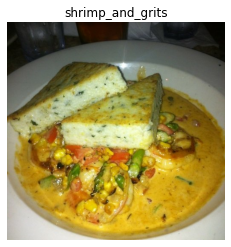

In [27]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to verify the label is associated with the right image
plt.axis(False)

## Create preprocessing functions for our data
Neural networks perform best when data is in a certain way (e.g. batched, normalized, etc).
However not all data comes like this.
In order to get it ready for a neural network, we have to write preprocessing functions and map it into your data.

What we know about our data
1. it's in uint8 datatype
2. it's comprised of all different sizes of image tensors
3. it's not scaled i.e. pixel values are 0-255 not 0-1.

what we know that models like:
1. data in `float32` dtype (or for mixed precision, `float16` and `float32`)
2. for batches, Tensorflow likes all the tensors within a batch to be all of the same sizes
3. scaled/normalized tensors always perform better

Therefore we have a framework for preprocessing function.

Since we're going to be using an `EfficientNetBX` pretrained model from `tf.keras.applications`, we don't need to rescale our data (these architectures have rescaling built in). 

This means our function needs to: 
1. reshape our images to all the same size
2. convert the dtype of our image tensors from uint8 to `float 32`

In [35]:
# make a functio for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  converts image dataype from 'unint8' -> 'float32' and
  reshapes image to [img_shape, img_shape, colour_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape])
  # image = image/255 # resizing function but not required for EfficientNetX
  return tf.cast(image, tf.float32), label # return a tuple of float32 image and a label


In [36]:
# preprocess single sample miage and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"image before preprocessing: \n {image[:2]}...., \nShape: {image.shape}, \nDatatype: {image.dtype}")
print(f"image after preprocessing: \n {preprocessed_img[:2]}...., \nShape: {preprocessed_img.shape}, \nDataype: {preprocessed_img.dtype}")

image before preprocessing: 
 [[[ 9  5  2]
  [10  6  3]
  [ 9  8  4]
  ...
  [ 3  4  0]
  [ 3  4  0]
  [ 3  4  0]]

 [[ 9  5  2]
  [10  6  3]
  [ 9  8  4]
  ...
  [ 3  4  0]
  [ 3  4  0]
  [ 3  4  0]]]...., 
Shape: (512, 512, 3), 
Datatype: <dtype: 'uint8'>
image after preprocessing: 
 [[[ 9.642858   5.642857   2.642857 ]
  [ 9.         8.         4.       ]
  [ 9.214286   8.214286   4.214286 ]
  ...
  [ 3.214264   4.214264   0.       ]
  [ 3.         4.         0.       ]
  [ 3.         4.         0.       ]]

 [[10.571429   6.571429   3.5714288]
  [ 9.066326   8.066326   4.066326 ]
  [ 9.214286   8.214286   4.214286 ]
  ...
  [ 3.214264   4.214264   0.       ]
  [ 3.         4.         0.       ]
  [ 3.         4.         0.       ]]]...., 
Shape: (224, 224, 3), 
Dataype: <dtype: 'float32'>


## batch and prepare datasets
https://www.tensorflow.org/guide/data_performance (read the Best Practice Summary)




